# Ingest and process data

This notebook loads the data that was stored on Box, and converts it to dataframe and dataset with a common format across all collections.

It provides functionality for downlaoding images.

In [65]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from weavingtools.collection_tools import SMGCollection, NMSCollection
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import chromadb

In [68]:
nms = NMSCollection(img_folder='nms_imgs')
nms.load_original_csvs(files=list(Path('data').glob('NMS_Metadata*.*')))
nms.save_csv('data/NMS.csv')

Using the following files [PosixPath('data/NMS_Metadata_2.csv'), PosixPath('data/NMS_Metadata_3.csv')]


In [69]:
nms.df.downloaded.value_counts()

False    5069
True     1487
Name: downloaded, dtype: int64

In [71]:
smg = SMGCollection( img_folder='smg_imgs')
smg.load_from_json('data/smg_objects_06_06_2022.json')
smg.save_csv('data/SMG.csv')

0it [00:00, ?it/s]

In [73]:
smg.df.downloaded.value_counts()

False    296155
True      72065
Name: downloaded, dtype: int64

#   Download images

In [13]:
collection = SMGCollection(img_folder=Path('smg_imgs'))
collection.load_from_csv('data/SMG.csv')


In [14]:
collection.fetch_images(n=10)

before downloading 69677
remaining images to download 129531


  0%|          | 0/10 [00:00<?, ?it/s]

after downloading 69687


In [15]:
# download images by category
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications',#'Photography','Photographic Technology',
            'Plastics and Modern Materials', 'Modern Materials', 'Textile Industry', 'Textiles Machinery',
            'Water Supply & Sanitation', 'Heat Engines (non steam)', 'Metallurgy', 'Hand and Machine Tools', 'Electricity Supply', 'Domestic Appliances', 
            'Tools of the Trade & Personal Accessories', 'Lighting', 'Motive Power', 'Coal Mining', 'Mining & Ore Dressing', 'Gas Industry', 'Heat', 'Nuclear Physics', 
            'Pumping Machinery', "Marine Engines", 'Industrial Metrology', 'Nuclear Energy', 'Environmental Science & Technology', 'Civil Engineering', 'Mechanical Power Transmission'
 ]
comms = smg_img_overview[smg_img_overview.category.isin(categories)]
print(comms.shape)

record_ids = set(comms.record_url.apply(lambda x: x.split('/')[-1]))
collection.fetch_images(record_ids=record_ids)

(21640, 6)
before downloading 69687
['486/219/medium_SMG00307832_0.jpg', '420/724/medium_1964_330_53__0006_.jpg', '420/725/medium_1964_330_53__0005_.jpg', '460/430/medium_SMG00078652_0.jpg', '439/271/medium_SMG00174226_0.jpg', '536/526/medium_2019_0497__0001_.jpg', '536/527/medium_2019_0497__0002_.jpg', '536/528/medium_2019_0497__0004_.jpg', '536/529/medium_2019_0497__0003_.jpg', '420/724/medium_1964_330_53__0006_.jpg', '420/725/medium_1964_330_53__0005_.jpg', '439/277/medium_SMG00174255_0.jpg', '439/278/medium_SMG00174256_0.jpg', '494/324/medium_1994_7263_0001_0.jpg', '494/325/medium_1994_7263_0002_0.jpg', '439/274/medium_SMG00174252_0.jpg', '462/952/medium_SMG00020107_0.jpg', '536/535/medium_2019_0501__0001_.jpg', '536/536/medium_2019_0501__0003_.jpg', '536/537/medium_2019_0501__0004_.jpg', '536/538/medium_2019_0501__0005_.jpg', '536/539/medium_2019_0501__0006_.jpg', '460/426/medium_SMG00078648_0.jpg', '460/429/medium_SMG00078651_0.jpg', '460/425/medium_SMG00078647_0.jpg', '439/276/m

  0%|          | 0/232 [00:00<?, ?it/s]

after downloading 69687


In [16]:
collection = NMSCollection(img_folder=Path('nms_imgs'))
collection.load_from_csv('data/NMS.csv')
#collection.fetch_images(n=5)

In [17]:
img_ids = [p for p in collection.df.img_loc.to_list() if isinstance(p,str)]
collection.fetch_images(imgs_ids=img_ids)

  0%|          | 0/1487 [00:00<?, ?it/s]

# Filter communications data

In [74]:
# open the spreadsheet with image lookup
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
# select the categories we want to include in the communications collections
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications',#'Photography','Photographic Technology',
            'Plastics and Modern Materials', 'Modern Materials', 'Textile Industry', 'Textiles Machinery',
            'Water Supply & Sanitation', 'Heat Engines (non steam)', 'Metallurgy', 'Hand and Machine Tools', 'Electricity Supply', 'Domestic Appliances', 
            'Tools of the Trade & Personal Accessories', 'Lighting', 'Motive Power', 'Coal Mining', 'Mining & Ore Dressing', 'Gas Industry', 'Heat', 'Nuclear Physics', 
            'Pumping Machinery', "Marine Engines", 'Industrial Metrology', 'Nuclear Energy', 'Environmental Science & Technology', 'Civil Engineering', 'Mechanical Power Transmission'
 ]
# select objects from based on these categories
df_comms = smg_img_overview[smg_img_overview.category.isin(categories)]
#print(df_comms.category.value_counts())
print([w for w in categories if w not in df_comms.category.value_counts().index])
# # get object ids for communication object
object_ids = df_comms.record_url.apply(lambda x: x.split('/')[-1])
print(f'Collected {len(object_ids)} object ids')
smg.df.img_path = smg.df.img_path.apply(lambda x: Path(x)) 
smg.df = smg.df[smg.df.record_id.isin(object_ids)]
smg.df = smg.df[smg.df.img_path.apply(lambda x: x.is_file() and not x.is_dir())].reset_index(drop=True)
smg.df.shape,df_comms.shape

['Modern Materials']
Collected 21640 object ids


((29666, 10), (21640, 6))

In [75]:
nms.df = nms.df[nms.df.img_name.str.endswith('.jpg').fillna(False).astype(bool) &  
                nms.df.img_name.str.startswith(('PF','MP')).fillna(False).astype(bool)
                ].reset_index(drop=True)
nms.df.downloaded = True
nms.df.shape

(1487, 10)

# Create dataframe for collection

In [76]:
# nms = NMSCollection(img_folder='nms_imgs')
# nms.load_from_csv('data/NMS.csv')

# smg = SMGCollection(img_folder='smg_imgs')
# smg.load_from_csv('data/SMG.csv')
nms.df.shape,smg.df.shape

((1487, 10), (29666, 10))

In [78]:
# add collection name to the dataframes to later we can filter by collection
smg.df['collection'] = smg.collection_name; nms.df['collection'] = nms.collection_name
# concatenate the dataframes
collection_df = pd.concat([smg.df,nms.df],axis=0, ignore_index=True)
# keep only rows for which we have an image stored locally
collection_df = collection_df[collection_df.img_path.apply(lambda x: Path(str(x)).is_file())]
# reset index so we can use it later in the database as ids
collection_df.reset_index(drop=True,inplace=True)
# convert image path to string to aoivd issues with the database
collection_df['img_path'] = collection_df.img_path.apply(lambda x: str(x))
print('Collections has',collection_df.shape[0],'rows')
# save the data to a csv file
collection_df.to_csv('data/heritage_weaver_data.csv')

Collections has 31153 rows


In [79]:
len(collection_df['record_id'].unique())

21717

In [80]:
collection_df['collection'].value_counts()

smg    29666
nms     1487
Name: collection, dtype: int64

## Describe Data

In [81]:
import seaborn as sns
sns.set_theme(style="whitegrid")
collection_df = pd.read_csv('data/heritage_weaver_data.csv')
collection_df.shape

(31153, 12)

<AxesSubplot:>

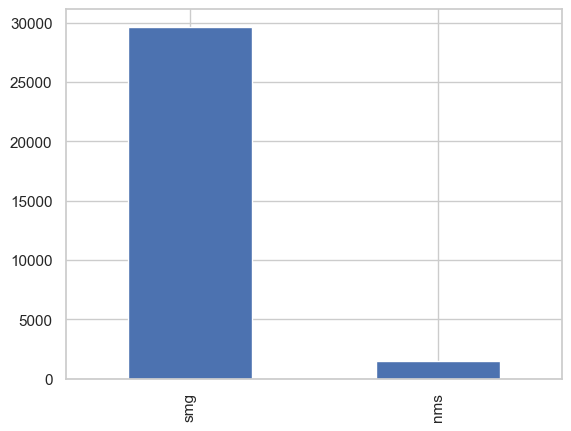

In [82]:
collection_df.collection.value_counts().plot(kind='bar')

<AxesSubplot:>

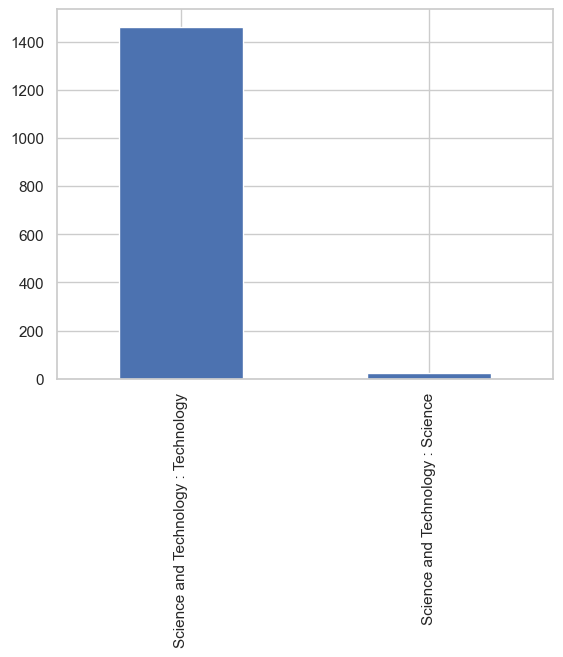

In [83]:
nms.df.category.value_counts().plot(kind='bar')

<AxesSubplot:>

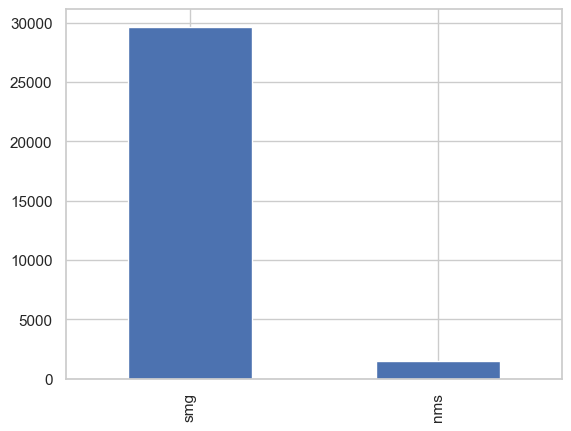

In [84]:
collection_df.collection.value_counts().plot(kind='bar')

In [85]:
collection_df.groupby(['collection', 'category'])['record_id'].count().reset_index().to_csv('data/collection_category_counts.csv')

# Create Vector Database

In [86]:
import pandas as pd
import chromadb
import json
from weavingtools.embedding_tools import SigLIPEmbedder, ImageLoaderRGB, index_data
from weavingtools.linkage_tools import plot_query_results

In [87]:
collection_df = pd.read_csv('data/heritage_weaver_data.csv')
print('Collections has',collection_df.shape[0],'rows')

Collections has 31153 rows


In [88]:
# select model to use for embedding both text and images
checkpoint = 'google/siglip-base-patch16-224' #'google/siglip-base-patch16-224' #'Kaspar/siglip-heritage-weaver-text' #'google/siglip-base-patch16-224'  'Kaspar/siglip-heritage-weaver-name'
# initialise the embedder which we will attach to the database
siglip_embedder = SigLIPEmbedder(checkpoint)
# initate the image loader
data_loader = ImageLoaderRGB()
# initiate the client
client = chromadb.PersistentClient(path="hw-08-10")

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [89]:
collection_name = 'heritage-weaver-base'
try:
    client.delete_collection(name=collection_name)
except Exception as e:
    print(e)

Collection heritage-weaver-base does not exist.


In [90]:
# initiate the collection in the database
collection_db = client.get_or_create_collection(
                                            name=collection_name, 
                                            metadata={"hnsw:space": "cosine"}, # we will use cosine distance for similarity search
                                            embedding_function=siglip_embedder, # the embedder for the collection (text and images)
                                            data_loader=data_loader # procedure for loading the image data
                                            )

In [91]:
collection_db.count()

0

In [92]:
index_data(collection_db, collection_df, batch_size=32)

indexing images...


  0%|          | 0/973 [00:00<?, ?it/s]

indexing text...


  0%|          | 0/678 [00:00<?, ?it/s]

In [94]:
collection_db.count()

108220

In [ ]:
# 107222

Oil cap lamp.

Oil cap lamp, coal mining


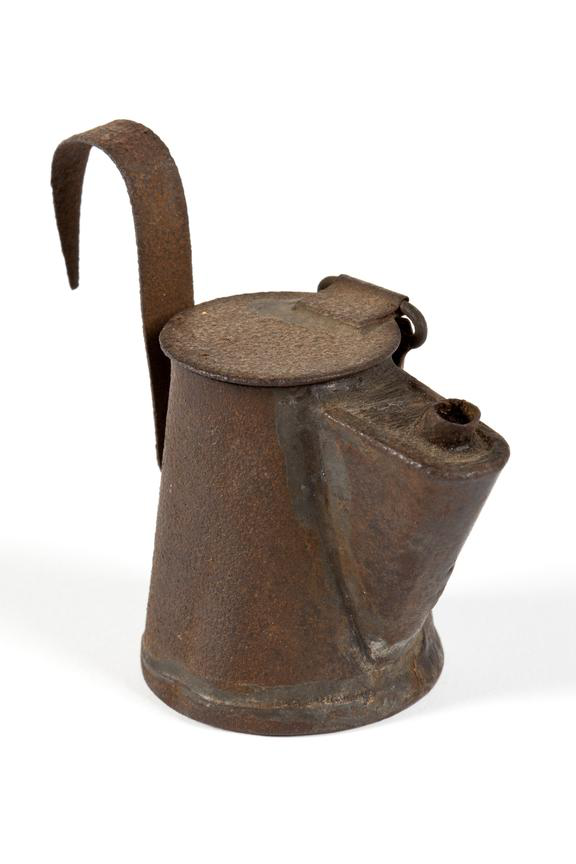

In [95]:

idx = 323
query_img = smg.df[smg.df.downloaded==True].img_path.iloc[idx]
print(smg.df[smg.df.downloaded==True].description.iloc[idx])
Image.open(query_img)

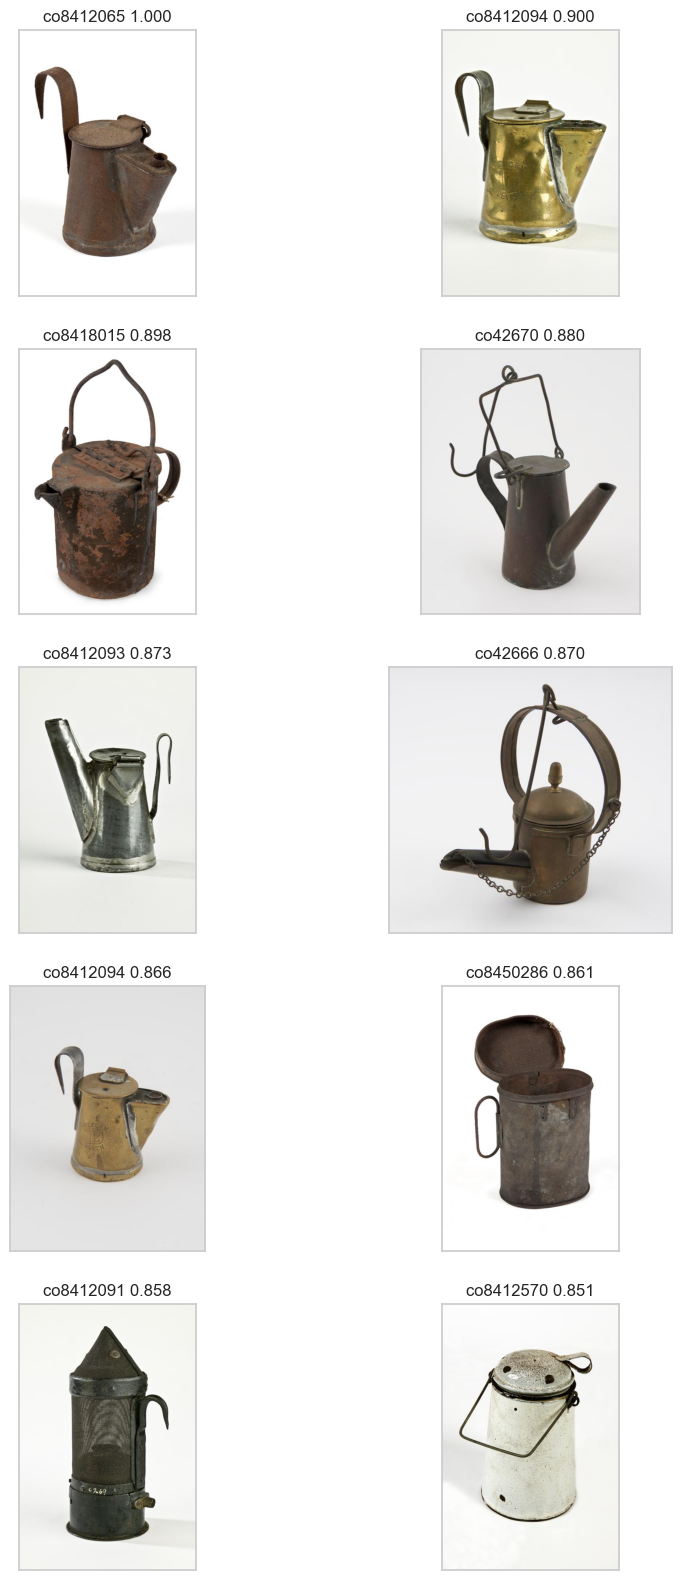

In [97]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}

results = collection_db.query(query_uris=[query_img],where=filters, n_results=25)
query_df = plot_query_results(results, source='img_path')

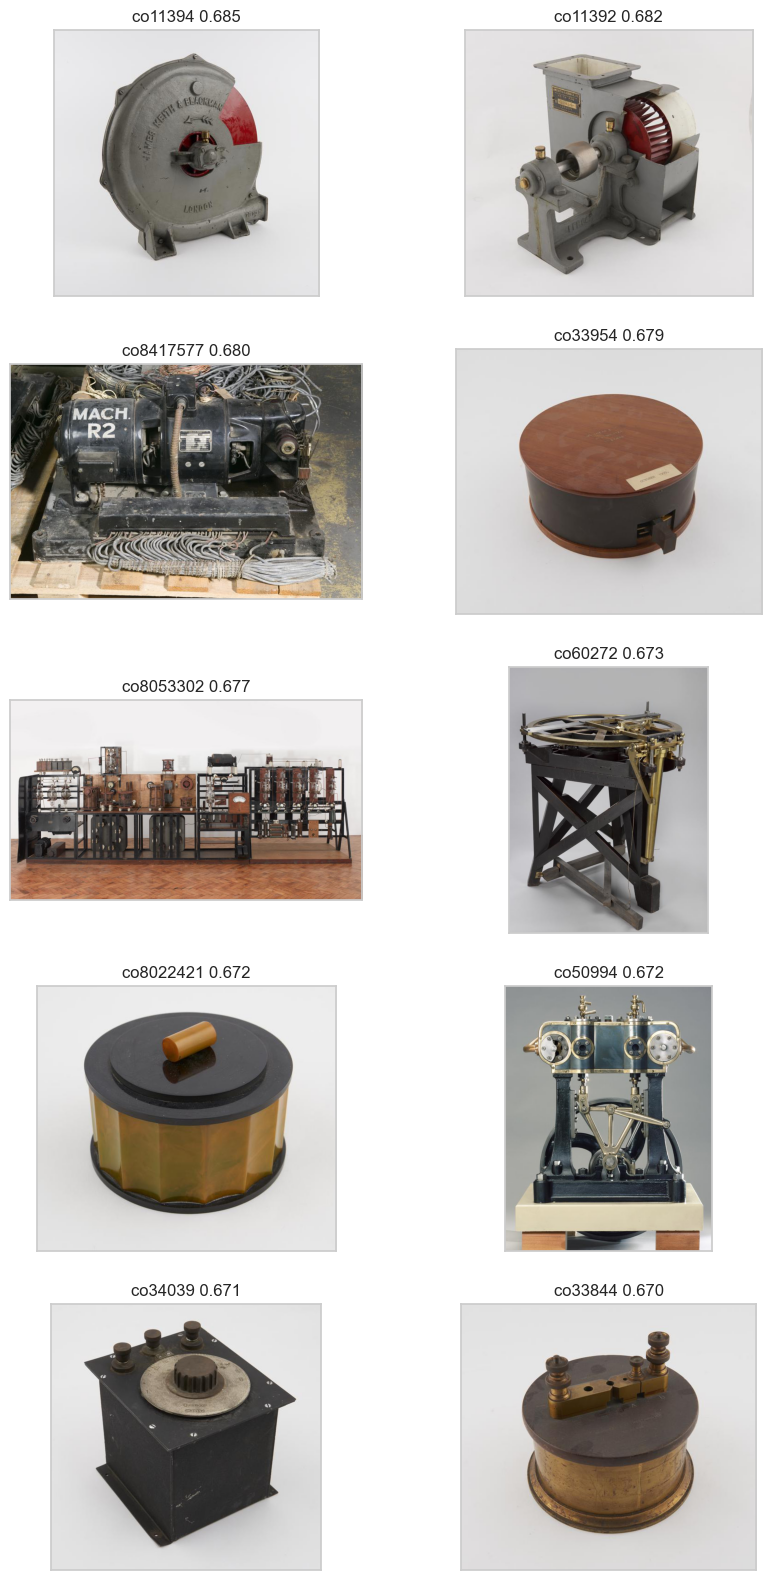

In [105]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "text"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}


results = collection_db.query(
                query_texts=[
                        """BTH valve, type A.T.26, serial No. 575, (RMW/J89 - McVitie Weston number), by British Thomson-Houston Company Limited."""
                    ],
                where=filters,n_results=100
        )
query_df = plot_query_results(results, source='img_path')

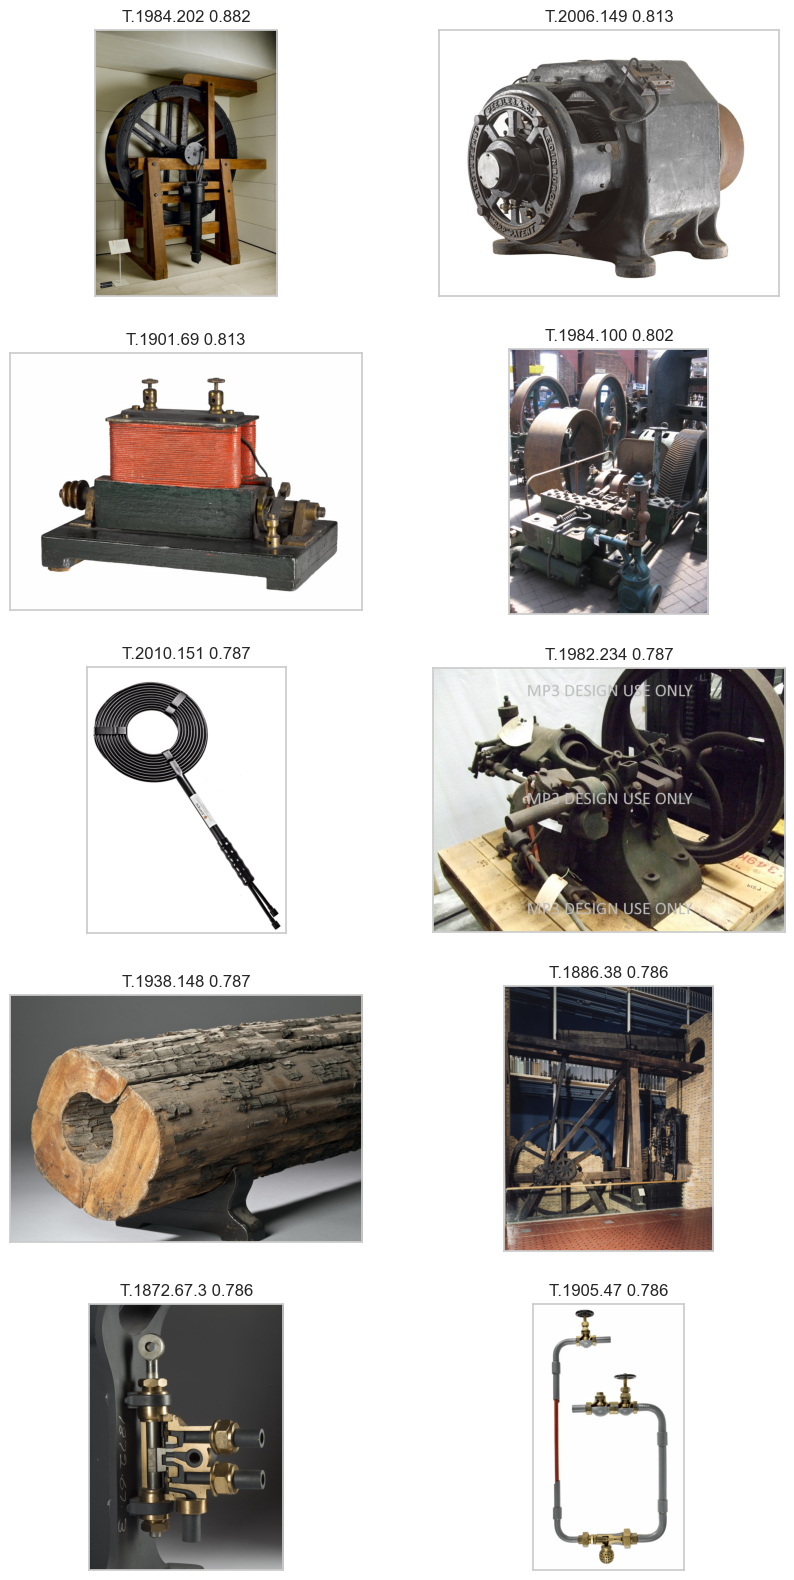

In [107]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "text"
            }
        },
        {
            "collection": {
                "$eq" : "nms"
            }
        }
    ]
}


results = collection_db.query(
                query_texts=[
                        """heath pump"""
                    ],
                where=filters,n_results=100
        )
query_df = plot_query_results(results, source='img_path')

In [ ]:
query_df.description.values[:10]

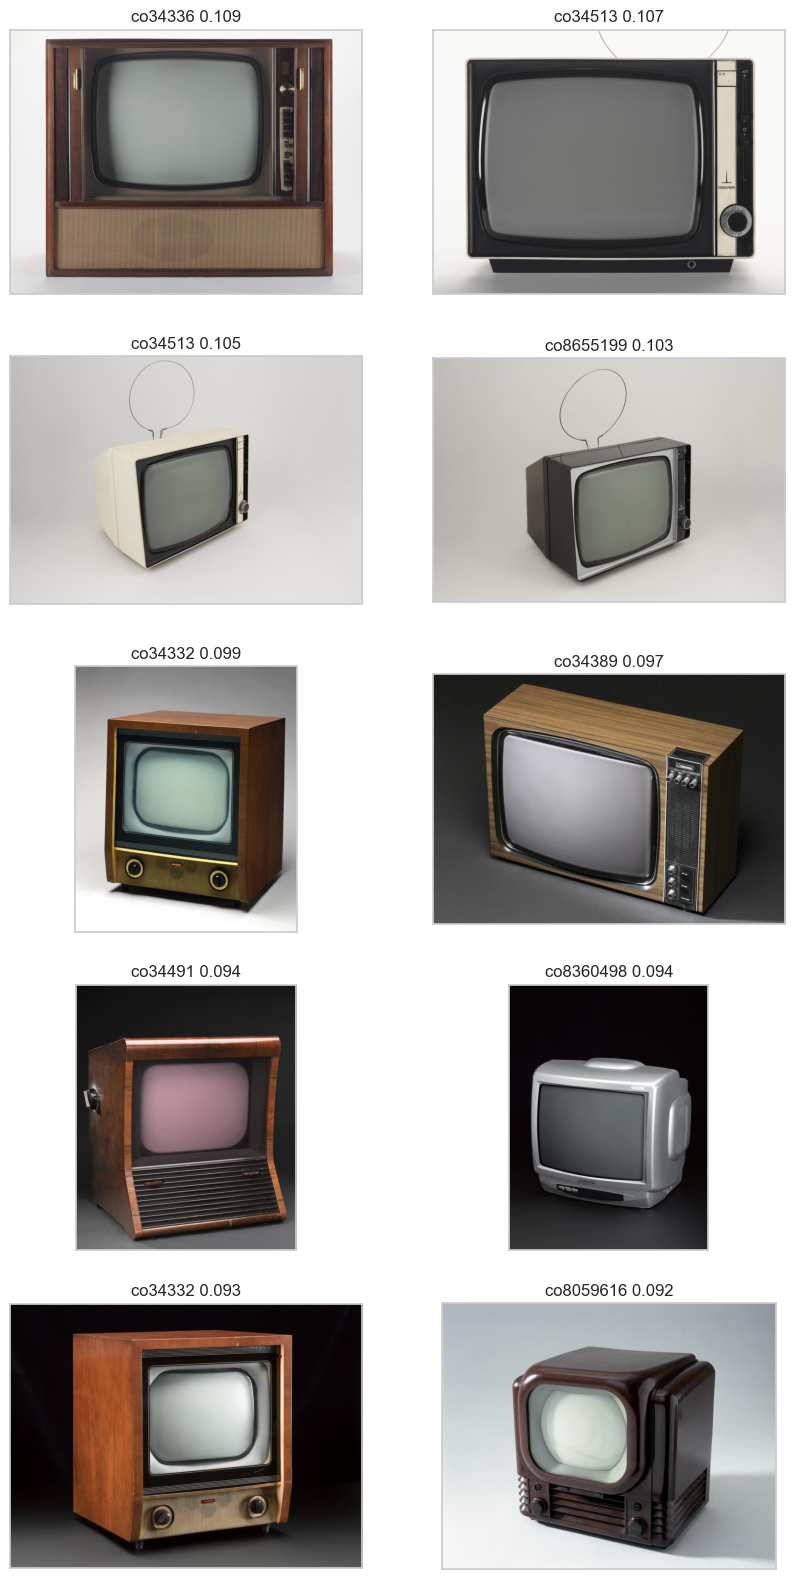

In [108]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}
results = collection_db.query(query_texts=["television"],
                             where=filters,#{"modality": "text"},
                             n_results=10)

query_df = plot_query_results(results, source='img_path')

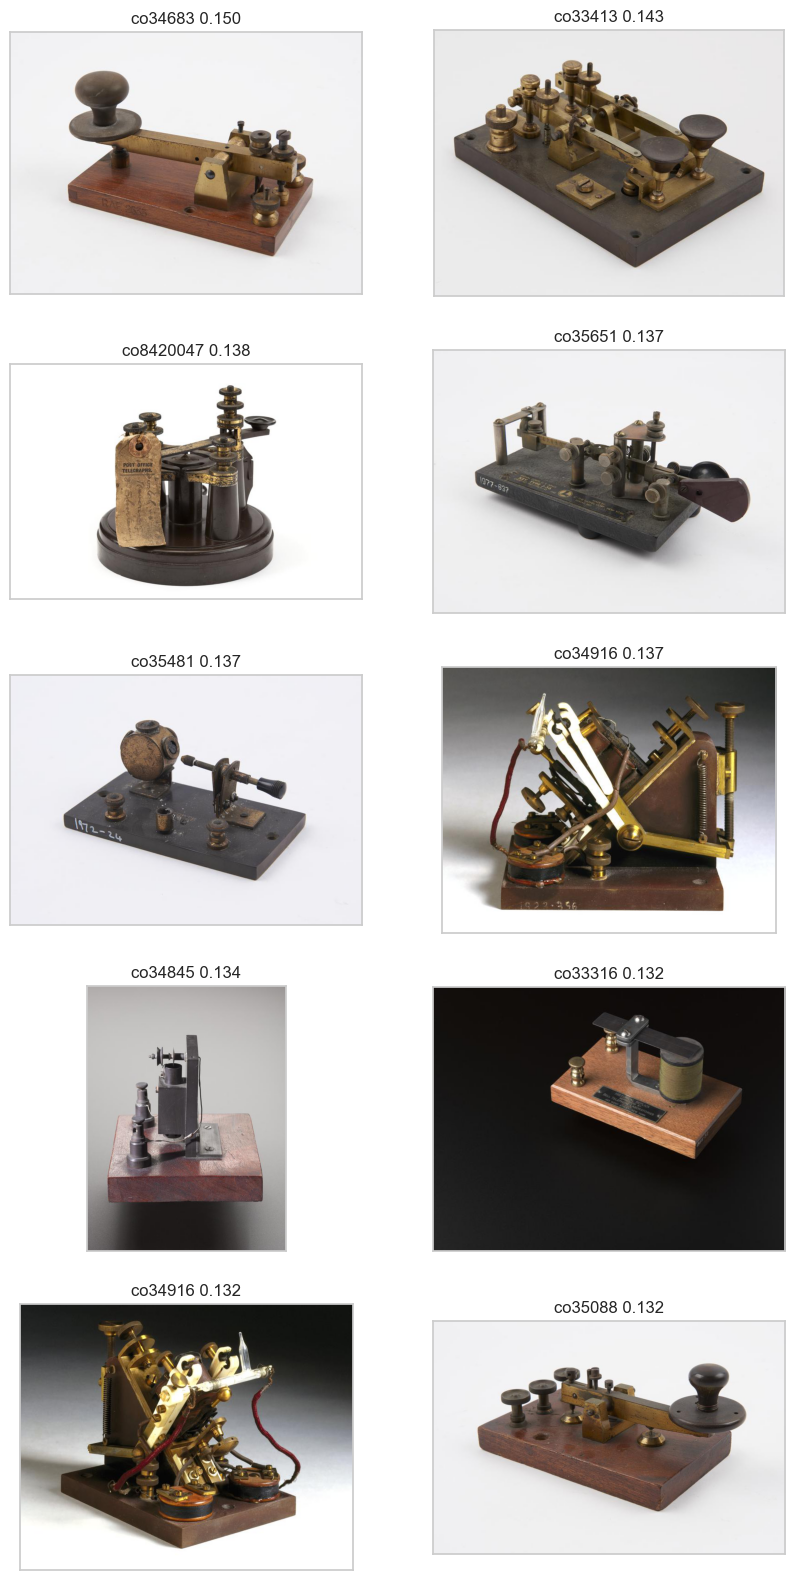

In [109]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}
results = collection_db.query(query_texts=["telegraph"],
                             where=filters,#{"modality": "text"},
                             n_results=10)

query_df = plot_query_results(results, source='img_path')

In [ ]:
query_df.description.values[:10]

In [ ]:

results = collection_db.query(query_texts=["red telephone"],
                             where={"modality": "image"},
                             n_results=10)

query_df = plot_query_results(results, collection_df)

## Fin.